## **Predicción del Precio del Oro**
1. Importación de librerías
2. Carga de datos con yfinance
3. Preprocesamiento + Ingeniería de características
4. Normalización y creación de secuencias
5. División de datos en train/val/test
6. Construcción del modelo LSTM
7. Entrenamiento
8. Evaluación y visualización básica (pred vs real)

In [ ]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import yfinance as yf
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Descarga de datos
df_oro = yf.download("GC=F", start="2010-01-01")
df_dxy = yf.download("DX-Y.NYB", start="2010-01-01")
df_bonos = yf.download("^TNX", start="2010-01-01")
df_inflacion = yf.download("TIP", start="2010-01-01")

# 3. Preparación del DataFrame
df = pd.concat([
    df_oro['Close'],
    df_dxy['Close'],
    df_bonos['Close'],
    df_inflacion['Close']
], axis=1)
df.columns = ['Oro', 'DXY', 'Bonos_10y', 'TIP']
df = df.dropna()

# 4. Feature Engineering
df['Ratio_Oro_Dolar'] = df['Oro'].shift(1) / df['DXY'].shift(1)
df['Inflacion_impl'] = df['TIP'].pct_change(periods=21)  # mensual
df['Tasa_Real'] = df['Bonos_10y'] - df['Inflacion_impl']
df['SMA_200'] = df['Oro'].rolling(window=200).mean()
df['Volatilidad'] = df['Oro'].rolling(window=20).std()

df = df.dropna()

df.info()
df.head(n = 10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 2010-10-19 to 2025-04-23
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Oro              3647 non-null   float64
 1   DXY              3647 non-null   float64
 2   Bonos_10y        3647 non-null   float64
 3   TIP              3647 non-null   float64
 4   Ratio_Oro_Dolar  3647 non-null   float64
 5   Inflacion_impl   3647 non-null   float64
 6   Tasa_Real        3647 non-null   float64
 7   SMA_200          3647 non-null   float64
 8   Volatilidad      3647 non-null   float64
dtypes: float64(9)
memory usage: 284.9 KB


,Oro,DXY,Bonos_10y,TIP,Ratio_Oro_Dolar,Inflacion_impl,Tasa_Real,SMA_200,Volatilidad
Date,,,,,,,,,
2010-10-19,1335.099976,78.180000,2.475,78.090225,17.823995,0.042449,2.432551,1189.230999,30.877646
2010-10-20,1343.300049,77.169998,2.470,78.069305,17.077257,0.038109,2.431891,1190.358999,28.257969
2010-10-21,1324.699951,77.419998,2.531,78.069305,17.407025,0.024990,2.506010,1191.391999,26.685358
2010-10-22,1324.400024,77.470001,2.563,78.090225,17.110566,0.023857,2.539143,1192.334499,25.251275
2010-10-25,1338.300049,77.099998,2.554,78.327682,17.095650,0.027723,2.526277,1193.360499,23.656457
2010-10-26,1338.000000,77.709999,2.636,77.901649,17.357978,0.027304,2.608696,1194.359500,21.800372
2010-10-27,1322.199951,78.150002,2.712,77.419762,17.217861,0.017953,2.694047,1195.217000,20.885568
2010-10-28,1342.099976,77.309998,2.661,77.699081,16.918745,0.014553,2.646447,1196.282999,19.654570
2010-10-29,1357.099976,77.269997,2.612,77.957520,17.359980,0.022491,2.589509,1197.386499,18.423582


In [ ]:
# 5. División temporal
train = df.loc['2019':'2022']
val = df.loc['2023']
test = df.loc['2024':]


# 6. Normalización
features = ['Oro', 'DXY', 'Bonos_10y', 'TIP', 'Ratio_Oro_Dolar', 'Inflacion_impl', 'Tasa_Real', 'SMA_200', 'Volatilidad']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
val_scaled = scaler.transform(val[features])
test_scaled = scaler.transform(test[features])

In [ ]:
# 7. Generadores de secuencias
look_back = 60
horizon = 5

def create_multistep_sequences(data, look_back, horizon):
    X, y = [], []
    for i in range(len(data) - look_back - horizon):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back:i+look_back+horizon, 0])  # solo precio oro [0]
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_sequences(train_scaled, look_back, horizon)
X_val, y_val = create_multistep_sequences(val_scaled, look_back, horizon)
X_test, y_test = create_multistep_sequences(test_scaled, look_back, horizon)

# 8. Construcción del modelo con 'Input'
model = Sequential([
    Input(shape=(look_back, len(features))),  # Definir el tamaño de la entrada
    LSTM(192,return_sequences=True),
    Dropout(0.35),
    LSTM(96),
    Dropout(0.15),
    Dense(horizon)  # horizon = 5 días
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Ver el resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 192)        │       155,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 96)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,597 (1.02 MB)

 Trainable params: 266,597 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 9. Entrenamiento
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(patience=7, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=48,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1104 - mae: 0.2493 - val_loss: 0.0790 - val_mae: 0.2735 - learning_rate: 0.0010
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - mae: 0.0883 - val_loss: 0.0371 - val_mae: 0.1851 - learning_rate: 0.0010
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0094 - mae: 0.0746 - val_loss: 0.0304 - val_mae: 0.1674 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - mae: 0.0673 - val_loss: 0.0328 - val_mae: 0.1744 - learning_rate: 0.0010
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0074 - mae: 0.0658 - val_loss: 0.0217 - val_mae: 0.1390 - learning_rate: 0.0010
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - mae: 0.0640 - val_loss: 0.0156 - val_mae: 0.1148 - learning_rate: 0.0010
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062 - mae: 0.0598 - val_loss: 0.0152 - val_mae: 0.1132 - learning_rate: 0.0010
Epoch 

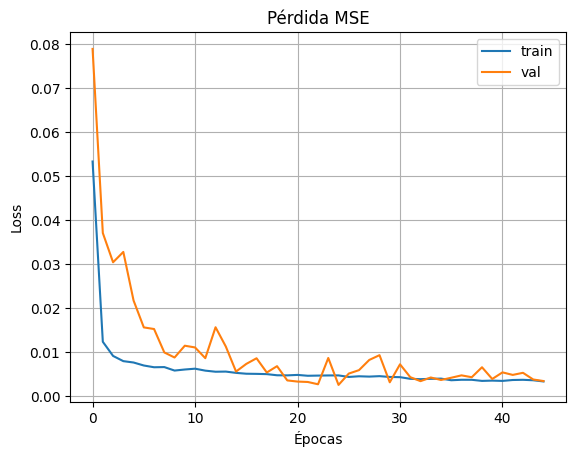

In [ ]:
# 10. Visualización de la pérdida
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Pérdida MSE")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 11. Evaluación en test
# Predicciones del modelo
preds = model.predict(X_test)

# Desnormalización
def desnormalizar_oro(scaler, data_norm):
    """
    Desnormaliza únicamente la columna de 'Oro' (índice 0) de los datos normalizados.
    """
    dummy = np.zeros((len(data_norm), len(features)))
    dummy[:, 0] = data_norm
    return scaler.inverse_transform(dummy)[:, 0]

# Desnormaliza los datos
y_test_desnorm = desnormalizar_oro(scaler, y_test.flatten())
preds_desnorm = desnormalizar_oro(scaler, preds.flatten())

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_desnorm.flatten(), preds_desnorm.flatten()))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_desnorm.flatten(), preds_desnorm.flatten())

# R² (coeficiente de determinación)
r2 = r2_score(y_test_desnorm.flatten(), preds_desnorm.flatten())

# Recuperamos el primer valor real de oro para usarlo como referencia
real_gold_value = y_test_desnorm.flatten()[0]  # Tomamos el primer valor real

# Calculamos el porcentaje de error promedio
error_abs = np.abs(y_test_desnorm - preds_desnorm)  # error absoluto
error_relativo = (error_abs / y_test_desnorm) * 100  # error relativo
porcentaje_error_promedio = np.mean(error_relativo)  # error promedio

# Resultados
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"Porcentaje de error promedio: {porcentaje_error_promedio:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
RMSE: 305.95
MAE: 273.20
R²: -0.59
Porcentaje de error promedio: 10.10%


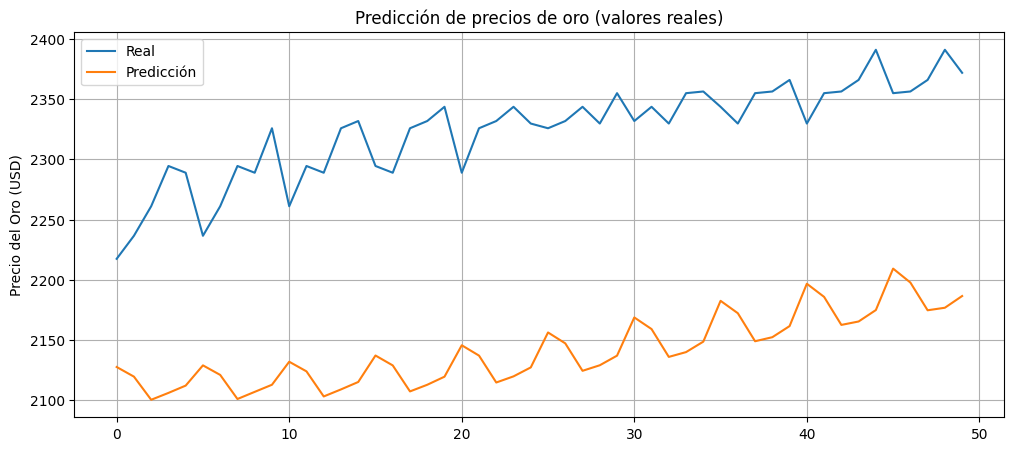

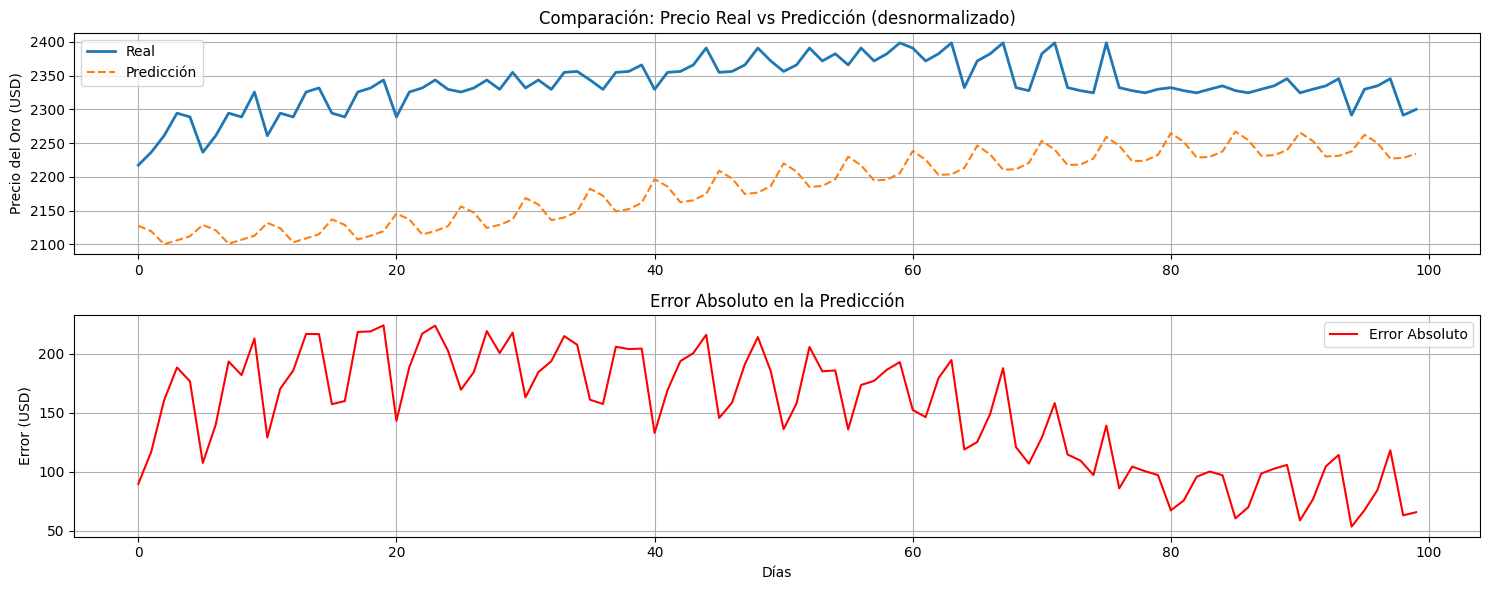

In [ ]:
# Gráfico de comparación (solo los primeros 50 valores)
plt.figure(figsize=(12, 5))
plt.plot(y_test_desnorm[:50].flatten(), label="Real")
plt.plot(preds_desnorm[:50].flatten(), label="Predicción")
plt.title("Predicción de precios de oro (valores reales)")
plt.ylabel("Precio del Oro (USD)")
plt.legend()
plt.grid()
plt.show()

# --- Comparación visual de predicción vs real + error absoluto ---

# Número de predicciones que se graficarán
N = 100

# Datos a graficar
real = y_test_desnorm[:N].flatten()
pred = preds_desnorm[:N].flatten()
error_abs_real = np.abs(real - pred)

plt.figure(figsize=(15, 6))

# 1. Predicción vs Real
plt.subplot(2, 1, 1)
plt.plot(real, label='Real', linewidth=2)
plt.plot(pred, label='Predicción', linestyle='--')
plt.title('Comparación: Precio Real vs Predicción (desnormalizado)')
plt.ylabel('Precio del Oro (USD)')
plt.legend()
plt.grid(True)

# 2. Error absoluto
plt.subplot(2, 1, 2)
plt.plot(error_abs_real, color='red', label='Error Absoluto')
plt.title('Error Absoluto en la Predicción')
plt.xlabel('Días')
plt.ylabel('Error (USD)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Guarda el modelo completo (estructura + pesos + configuración de entrenamiento)
model.save('modelo_prediccion_oro.keras')

# Alternativamente, puedes guardarlo en formato HDF5
# model.save('modelo_prediccion_oro.h5')


In [ ]:
import joblib

# Guarda el objeto scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']